### Libraries

In [1]:
import sys
modules = '../python-scripts/'
sys.path.append(modules)

In [2]:
from mcnulty import *

In [3]:
%matplotlib inline

## Cleaning
In this notebook, I load in the entire raw dataset from PSQL, clean, then upload the entire cleaned dataset at once. This process was done somewhat manually, but it was worth the time to inspect each feature.

In [4]:
cleaned_columns = {}

In [5]:
def clean_with_dict(vN, new_name, col_dict, sql_type='TEXT'):
    """Used on categorical data"""
    df[new_name] = df[vN].apply(lambda x: col_dict[x])
    cleaned_columns[new_name] = sql_type

In [6]:
def rename_column(vN, new_name, sql_type='TEXT', unknown = False):
    """Used on continuous data"""
    df[new_name] = df[vN]
    cleaned_columns[new_name] = sql_type
    
    if unknown:
        df[new_name] = df[new_name].apply(lambda x: np.nan if x==unknown else x)

In [7]:
def split_into_quartiles(col):
    """Used on continuous data"""
    one = df[col].quantile(0.25)
    two = df[col].quantile(0.5)
    three = df[col].quantile(0.75)

    def apply_function(x):
        if x <= one:
            return 'first_quartile'
        elif x > one and x <= two:
            return 'second_quartile'
        elif x > two and x <= three:
            return 'third_quartile'
        else:
            return 'fourth_quartile'
        
    df[col] = df[col].apply(apply_function)

In [8]:
def continuous_data(vN, new_name, unknown=False):
    rename_column(vN, new_name, unknown=unknown)
    split_into_quartiles(new_name)

#### Raw Data

In [9]:
df = load_table('raw')

In [10]:
df.head()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,...,v140,v141,v142,v143,v144,v145,v146,v147,v148,v149
0,9574.0,2.0,1.0,1.0,2.0,4.0,1.0,800.0,1.0,2.0,...,7.0,98.0,99.0,99.0,99.0,99.0,99.0,99.0,11.0,98.0
1,9574.0,2.0,1.0,2.0,3.0,4.0,1.0,810.0,1.0,1.0,...,98.0,98.0,99.0,99.0,99.0,99.0,99.0,99.0,11.0,98.0
2,9574.0,2.0,1.0,3.0,4.0,4.0,1.0,810.0,8.0,1.0,...,98.0,98.0,99.0,99.0,99.0,99.0,99.0,99.0,11.0,98.0
3,9574.0,2.0,1.0,4.0,5.0,4.0,1.0,210.0,1.0,3.0,...,98.0,98.0,99.0,99.0,99.0,99.0,99.0,99.0,2.0,98.0
4,9574.0,2.0,1.0,5.0,7.0,4.0,1.0,510.0,1.0,3.0,...,98.0,98.0,6.0,98.0,98.0,6.0,98.0,98.0,5.0,6.0


Column v4 is a unique identifier for this table. But with the index in pandas, this is unnecessay.

### Targets

#### No. of felonies while on probation
Fix this. Felony=98 must be turned to nan

In [11]:
df['v116'].value_counts()

0.0     7075
1.0     2210
98.0    1428
2.0      896
3.0      374
4.0      189
5.0      100
6.0       43
7.0       31
8.0       18
9.0        2
10.0       2
12.0       1
Name: v116, dtype: int64

In [12]:
df['reoffend'] = df['v116'].apply(lambda x: 1 if x>0 else 0)
df.rename(columns={'v116': 'felony_count'}, inplace=True)

In [13]:
# The order here becomes important when uploading the cleaned data to sql.
cleaned_columns['felony_count'] = 'DOUBLE PRECISION'
cleaned_columns['reoffend'] = 'DOUBLE PRECISION'

### Race & Ethnicity

In [14]:
clean_with_dict('v113', 'race', race_dict)
clean_with_dict('v114', 'ethnicity', ethnicity_dict)

### Features
#### Case Weight
Many features are a listed as a multiple of the case weight. For example, under the Age column, age is not listed. Instead, age times case weight is listed.

In [15]:
rename_column('v61', 'case_weight', sql_type = 'DOUBLE PRECISION')

#### Number of Convictions

In [16]:
continuous_data('v7', 'convictions', unknown = 98)

#### Three Digit Offense Code

In [17]:
clean_with_dict('v8', 'offense_type', offense_dict)

#### Sex

In [18]:
clean_with_dict('v9', 'sex', sex_dict)

#### Age
Age is one of the columns that is scaled by the case weight. Very important do un-scale each feature like this.

In [19]:
#rename_column('v99', 'age', 'DOUBLE PRECISION', unknown = 9998)
df['v99'] = df['v99']/df['case_weight']

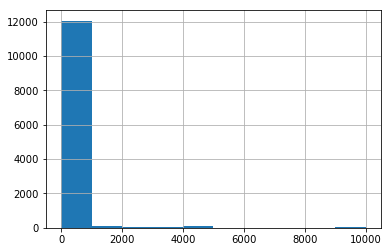

In [20]:
df['v99'].hist();

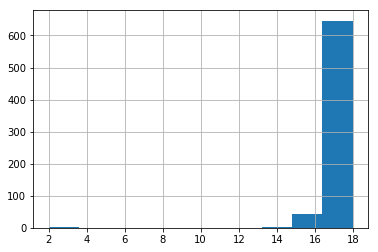

In [21]:
df.loc[df['v99'] <= 18]['v99'].hist();

In [22]:
df.loc[df['v99'] < 10]

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,...,v147,v148,v149,reoffend,race,ethnicity,case_weight,convictions,offense_type,sex
6781,9574.0,2.0,1.0,6782.0,1052.0,4.0,1.0,830.0,1.0,2.0,...,98.0,9.0,8.0,1,White,Hispanic,20.0,first_quartile,Drug possession,Male


In [23]:
continuous_data('v99', 'age', unknown=9998)

Later, filter out the two-year-old felon.

#### Various Probationer Characteristics

In [24]:
clean_with_dict('v10', 'time_employed', employed_dict)
clean_with_dict('v13', 'education', edu_dict)
clean_with_dict('v14', 'address_changes', address_dict)
clean_with_dict('v15', 'drug_use', drug_dict)
clean_with_dict('v16', 'prior_felonies', prior_dict)

#### Converting several columns straight from float data to text data
The model will treat is all as categorical anyway.

In [25]:
rename_column('v20', 'jail_imposed')
rename_column('v63', 'previously_on_probation')
rename_column('v130', 'jurisdiction')
rename_column('v136', 'drug_treatment')
rename_column('v140', 'previous_felony_type')

### Write dataframe to CSV

#### Drop invalid entries
For this project, we are not imputing unknown values. In future models, we should explore if that improves.

In [26]:
for column in df.columns:
    if column not in cleaned_columns.keys():
        df.drop(column, axis=1, inplace=True)

In [27]:
df.shape

(12369, 19)

In [28]:
df = df.dropna()
df['index'] = df.index

In [29]:
df = df.loc[df['age'] != 2]

In [30]:
df.shape

(12369, 20)

In [31]:
filepath = '../data/cleaned_data.csv'
df.to_csv(filepath, index=False)

### Load into PSQL

In [32]:
cleaned_columns

{'address_changes': 'TEXT',
 'age': 'TEXT',
 'case_weight': 'DOUBLE PRECISION',
 'convictions': 'TEXT',
 'drug_treatment': 'TEXT',
 'drug_use': 'TEXT',
 'education': 'TEXT',
 'ethnicity': 'TEXT',
 'felony_count': 'DOUBLE PRECISION',
 'jail_imposed': 'TEXT',
 'jurisdiction': 'TEXT',
 'offense_type': 'TEXT',
 'previous_felony_type': 'TEXT',
 'previously_on_probation': 'TEXT',
 'prior_felonies': 'TEXT',
 'race': 'TEXT',
 'reoffend': 'DOUBLE PRECISION',
 'sex': 'TEXT',
 'time_employed': 'TEXT'}

In [33]:
columns_to_add = [name + ' ' + dtype + ', ' for name, dtype in cleaned_columns.items()]

In [34]:
sql_command = 'CREATE TABLE clean ('
for column in columns_to_add:
    sql_command += column
    
sql_command = sql_command[:-2] + ', index DOUBLE PRECISION, PRIMARY KEY (index));'
sql_command

'CREATE TABLE clean (felony_count DOUBLE PRECISION, reoffend DOUBLE PRECISION, race TEXT, ethnicity TEXT, case_weight DOUBLE PRECISION, convictions TEXT, offense_type TEXT, sex TEXT, age TEXT, time_employed TEXT, education TEXT, address_changes TEXT, drug_use TEXT, prior_felonies TEXT, jail_imposed TEXT, previously_on_probation TEXT, jurisdiction TEXT, drug_treatment TEXT, previous_felony_type TEXT, index DOUBLE PRECISION, PRIMARY KEY (index));'

In [35]:
df.head()

,felony_count,reoffend,race,ethnicity,case_weight,convictions,offense_type,sex,age,time_employed,education,address_changes,drug_use,prior_felonies,jail_imposed,previously_on_probation,jurisdiction,drug_treatment,previous_felony_type,index
0,0.0,0,Black,Non-Hispanic,3.0,first_quartile,Miscellaneous,Male,first_quartile,40 to 60 percent,Some high school,None,Not ascertained,None,8.0,1.0,1.0,4.0,7.0,0
1,0.0,0,Black,Non-Hispanic,3.0,first_quartile,Sex related offenses,Male,fourth_quartile,>60 percent,High school (GED),One,No drug abuse problem,None,8.0,2.0,1.0,8.0,98.0,1
2,0.0,0,Black,Non-Hispanic,3.0,first_quartile,Sex related offenses,Unknown,fourth_quartile,>60 percent,Some high school,None,No drug abuse problem,None,8.0,2.0,1.0,1.0,98.0,2
3,0.0,0,Black,Non-Hispanic,1.0,first_quartile,Forcible Rape,Male,fourth_quartile,<40 percent,Grade school,Two or more,No drug abuse problem,One,8.0,2.0,1.0,1.0,98.0,3
4,1.0,1,Black,Unknown,3.0,first_quartile,Residential,Male,first_quartile,<40 percent,Some high school,None,Not ascertained,One,8.0,2.0,1.0,8.0,98.0,4


In [36]:
r"\COPY clean FROM '/Users/Joe/Documents/Metis/Projects/metis-03-mcnulty/data/cleaned_data.csv' DELIMITER ',' CSV HEADER;"

"\\COPY clean FROM '/Users/Joe/Documents/Metis/Projects/metis-03-mcnulty/data/cleaned_data.csv' DELIMITER ',' CSV HEADER;"

The above PSQL commands can be copy and pasted into the terminal. (Remove the first \ from the copy command.)